# Baseline for the CryptoBERT model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys

# PATH CONSTANTS
ABSOLUTE_PATH = "/content/drive/My Drive/sentix_nlp"
PREPROCESSED_DATA_DIR = ABSOLUTE_PATH + "/data/preprocessed"

sys.path.insert(0, ABSOLUTE_PATH)

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import (
  AutoModelForSequenceClassification,
  AutoTokenizer,
  Trainer,
  TrainingArguments,
  EvalPrediction
)
from sklearn.metrics import (
  classification_report,
  confusion_matrix,
  accuracy_score,
  ConfusionMatrixDisplay
)
from scipy.special import softmax
from utils import NewsDataset, compute_metrics


# ENV VARIABLES
os.environ["WANDB_DISABLED"] = "true"

# MODEL CONSTANTS
MODEL_NAME="ElKulako/cryptobert"
NUM_LABELS=3
BATCH_SIZE=16

## Load the model and tokenizer

To get the baseline results, I have used the base model without any fine-tuning, and only adapted the classification head for the sentiment task using 3 classes.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS)

### Switch to CUDA

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Load the preprocessed data

In [ ]:
test_set_path = os.path.join(PREPROCESSED_DATA_DIR, "coindesk_test.csv")
test_df = pd.read_csv(test_set_path)

test_df.head()

,full_text,label
0,breaking strategy acquire 3459 bitcoin for 28580 million . the post breaking strategy acquire 34...,2
1,white house economic adviser hassett on china we are prioritizing trading partner for talk fox n...,1
2,susd drop below 07 a synthetix stablecoin face prolonged depeg . the algorithmic stablecoin susd...,0
3,investor rejoice a pi coin surge beyond expectation . pi coin ha achieved unexpected price gain ...,2
4,the coolest meme coin ha arrived don ’ t miss out on arctic pablo – plus update on peanut the sq...,2


In [ ]:
X_test, y_test = test_df['full_text'].values, test_df['label'].values
test_dataset = NewsDataset(X_test, y_test, tokenizer)

## Inference on base model

In [ ]:
def _compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    preds = np.argmax(logits, axis=-1)
    return compute_metrics(preds, labels)

training_args = TrainingArguments(
    # output_dir='./results',
    per_device_eval_batch_size=BATCH_SIZE,
    do_train=False,
    do_eval=True,
    report_to=["tensorboard"],
    logging_dir='./logs'
)

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    compute_metrics=_compute_metrics,
    eval_dataset=test_dataset
)

<ipython-input-52-ff902760b591>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
baseline_metrics = trainer.evaluate()
baseline_metrics

{'eval_loss': 2.2453179359436035,
 'eval_model_preparation_time': 0.0027,
 'eval_accuracy': 0.5043478260869565,
 'eval_precision': 0.7080491810873121,
 'eval_recall': 0.5043478260869565,
 'eval_f1': 0.47159666755745466,
 'eval_runtime': 14.8231,
 'eval_samples_per_second': 100.856,
 'eval_steps_per_second': 6.341}

In [ ]:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.02      0.04       335
           1       0.32      0.75      0.45       390
           2       0.78      0.59      0.67       770

    accuracy                           0.50      1495
   macro avg       0.70      0.45      0.39      1495
weighted avg       0.71      0.50      0.47      1495



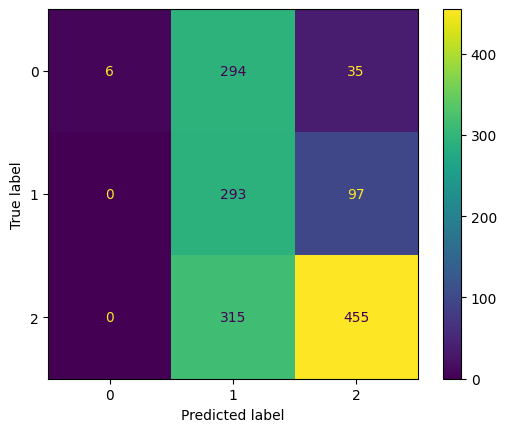

In [ ]:
cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Error Analysis

Here is a short analysis of the performance on different examples from the testing set. The goal here is to find out where CryptoBERT is struggling to perform well due to e.g., newer jargon, cryptocurrency coins, exchanges, etc.

In [ ]:
target_names = ['Negative', 'Neutral', 'Positive']

predictions = trainer.predict(test_dataset)
logits = predictions.predictions  # shape (n_examples, n_labels)

probs = softmax(logits, axis=1)
preds = np.argmax(probs, axis=1)
confidences = probs.max(axis=1)

results_df = test_df.copy()
results_df['predicted_label'] = preds
results_df['confidence'] = confidences
results_df['correct'] = results_df['predicted_label'] == results_df['label']

results_df['true_label_str'] = results_df['label'].map(lambda i: target_names[i])
results_df['pred_label_str'] = results_df['predicted_label'].map(lambda i: target_names[i])

sample_size = 10
samples = (
    results_df
    .groupby('label', group_keys=False)
    .apply(lambda grp: grp.sample(sample_size, random_state=42))
    .reset_index(drop=True)
)

samples['text_snippet'] = samples['full_text']
display_df = samples[[
    'text_snippet',
    'true_label_str',
    'pred_label_str',
    'confidence',
    'correct'
]]
pd.set_option('display.max_colwidth', 100)
display_df

<ipython-input-54-fef181c9f921>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(sample_size, random_state=42))


,text_snippet,true_label_str,pred_label_str,confidence,correct
0,crypto lending market plunge 43 a cefi collapse reshapes market survey show . the total size of ...,Negative,Neutral,0.924241,False
1,shocking mantra price crash unveiling onchain data behind the market selloff . the cryptocurrenc...,Negative,Neutral,0.631865,False
2,solana whale sell 46 million in token could a deeper correction be ahead . a significant 46 mill...,Negative,Neutral,0.971089,False
3,shibarium ’ s latest milestone fails to stop shib ’ s nosedive detail . tldr the l2 blockchain s...,Negative,Neutral,0.778343,False
4,decentralized exchange kiloex freeze platform following 75m exploit . decentralized exchange kil...,Negative,Neutral,0.736372,False
5,buterin call polymarket ’ s bet on muskfong pregnancy ‘ tasteless ’ . influencer tiffany fong cl...,Negative,Neutral,0.910139,False
6,bitcoin hashrate exceeds one zetahash for the first time . the intraday value at the peak wa 102...,Negative,Positive,0.575383,False
7,dogecoin whale offload over 132 billion doge in 48 hour – riskoff or panic selling . dogecoin is...,Negative,Neutral,0.844475,False
8,om token price crash over 90—binance explains what ’ s going on . mantra ’ s native token om saw...,Negative,Neutral,0.791536,False
9,trump ’ s tariff decision signal uncertain future for the u economy and cryptocurrencies . trump...,Negative,Neutral,0.941033,False


### Old analysis (not working)

In [ ]:
# Select a few examples from each class to analyse
sample_size, examples = 5, []

for label in [0, 1, 2]:
    class_df = test_df[test_df['label'] == label].sample(sample_size, random_state=42)
    sample_texts = class_df['full_text'].tolist()
    sample_labels = class_df['label'].tolist()

    # Get predictions
    sample_encodings = tokenizer(
        sample_texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )
    input_ids = sample_encodings["input_ids"].to(device)
    attention_mask = sample_encodings["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
        preds = np.argmax(probs, axis=-1)

    for i in range(len(sample_texts)):
        examples.append({
            'text': sample_texts[i][:100] + "...",  # Truncate for display
            'true_label': target_names[sample_labels[i]],
            'predicted_label': target_names[preds[i]],
            'confidence': probs[i][preds[i]],
            'correct': sample_labels[i] == preds[i]
        })


examples_df = pd.DataFrame(examples)
# pd.set_option('display.max_colwidth', 100)

examples_df

,text,true_label,predicted_label,confidence,correct
0,"‘black monday’ strikes the crypto market as bitcoin plunges below 77,000—has the bear market beg...",Negative,Neutral,0.873209,False
1,shibarium’s latest milestone fails to stop shib’s nosedive: details. tl;dr the l2 blockchain sol...,Negative,Negative,0.500560,True
2,"former employee claims he spied for deel, allegedly paid 5,000 monthly in ethereum to target rip...",Negative,Neutral,0.843595,False
3,"trump's tariffs cause market turmoil, dragging down asia-pacific trade. asia-pacific stocks, in ...",Negative,Neutral,0.475961,False
4,cardano tests 0.63 support as downtrend threatens further losses. cardano is trading inside a de...,Negative,Neutral,0.852149,False
5,is dogecoin ready for a breakout after hitting this key support?. doge's extended consolidation ...,Neutral,Neutral,0.615536,True
6,"top cryptocurrencies to watch: sonic, xrp, cardano, solana. cryptocurrency prices wavered as the...",Neutral,Positive,0.777746,False
7,binance launches bank lorenzo protocol u perpetual contract with 50x leverage today. in a signif...,Neutral,Neutral,0.678396,True
8,dogecoin 0.05 major warning signs and why doge whales are loading up on mutuum finance mutm. a s...,Neutral,Positive,0.766886,False
9,"bitcoin’s recent drop to 74,400: analyzing potential recovery and key resistance levels. bitcoin...",Neutral,Neutral,0.567618,True
